In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path

# 

In [2]:
conditions = ["CTRL", "PM"]
geo_accessions=[["GSM8385872", "GSM8385873"], ["GSM8385874", "GSM8385875"]]

url_template = "https://www.ncbi.nlm.nih.gov/geo/download/?acc={}&format=file&file={}%5F{}%5F{}%5F{}%2E{}%2Egz"

def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Downloaded {local_filename}")

sample_adatas = []
sample_names = []
for condition, condition_geos in zip(conditions, geo_accessions):
    for i, geo_accession in enumerate(condition_geos):
        mtx_url = url_template.format(geo_accession, geo_accession, condition, i+1, "matrix", "mtx")
        barcode_url = url_template.format(geo_accession, geo_accession, condition, i+1, "barcodes", "tsv")
        feature_url = url_template.format(geo_accession, geo_accession, condition, i+1, "features", "tsv")

        sample_name = f"{condition}_{i+1}"
        sample_path = os.path.join("data", sample_name)

        os.makedirs(sample_path , exist_ok = True)

        mtx_path = os.path.join(sample_path, "matrix.mtx.gz")
        barcode_path = os.path.join(sample_path, "barcodes.tsv.gz")
        feature_path = os.path.join(sample_path, "features.tsv.gz")

        if not (Path(mtx_path).exists() and Path(barcode_path).exists() and Path(feature_path).exists()):
            download_file(mtx_url, mtx_path)
            download_file(barcode_url, barcode_path)
            download_file(feature_url, feature_path)

        sample_adata = sc.read_10x_mtx(sample_path)
        sample_adata.obs["sample"] = sample_name
        sample_adata.obs["condition"] = condition

        sample_adatas.append(sample_adata)
        sample_names.append(sample_name)

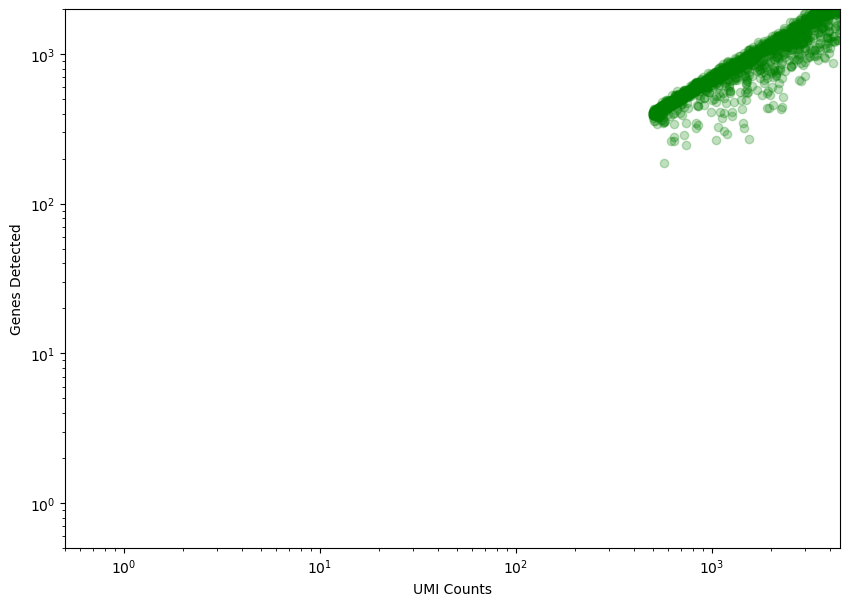

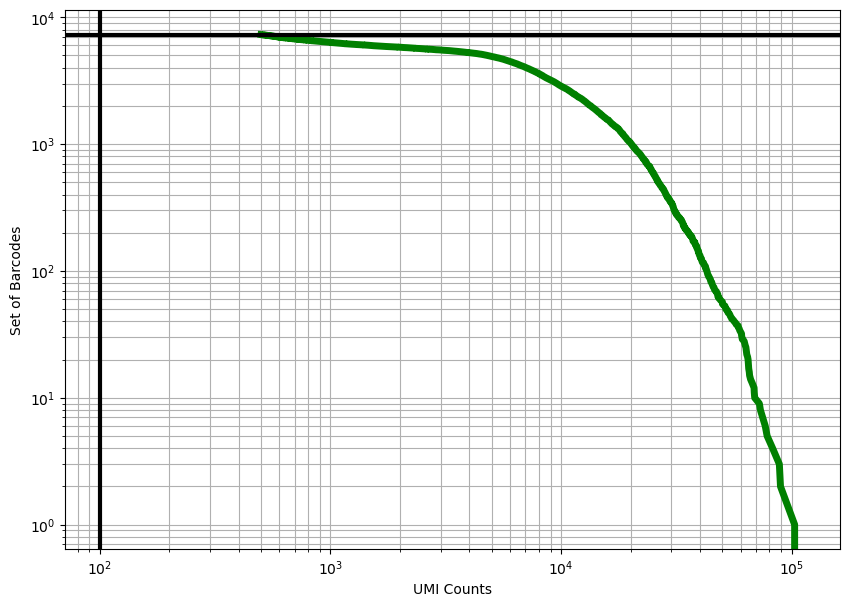

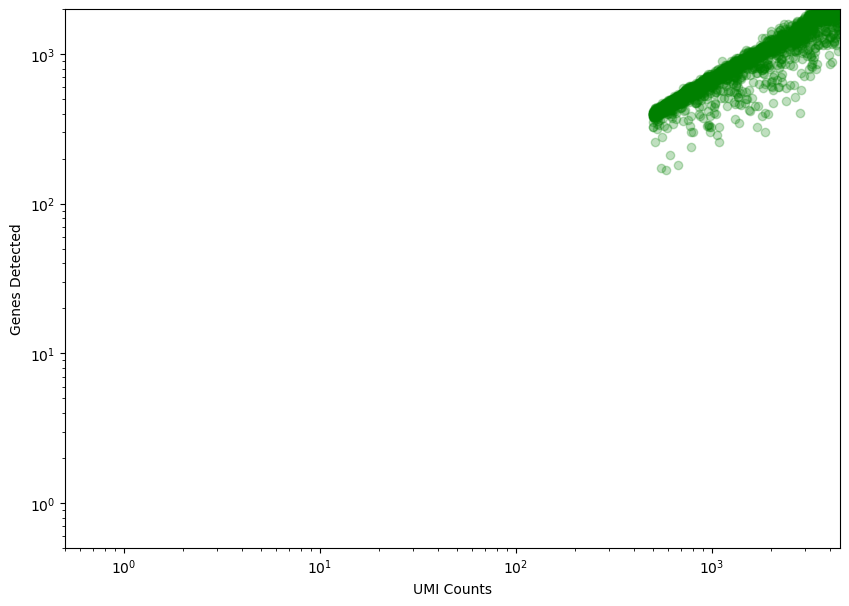

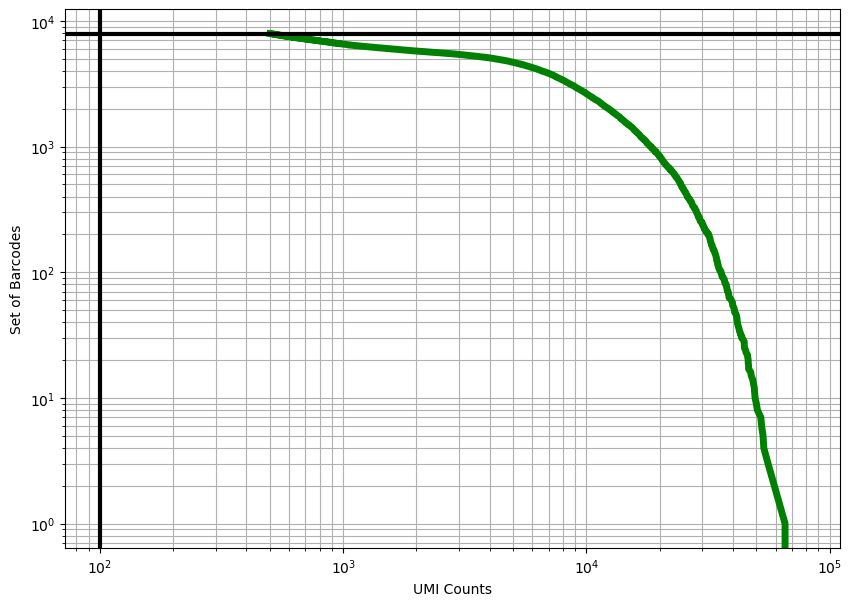

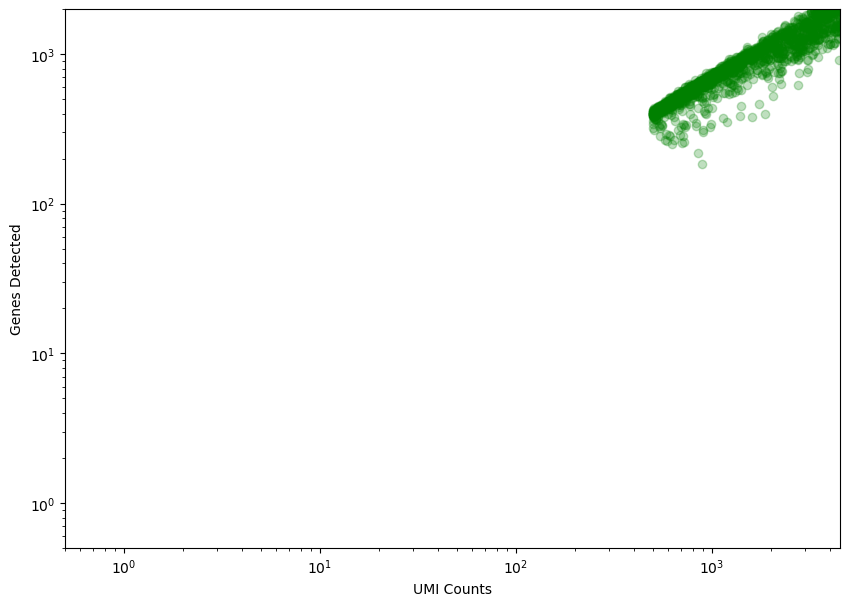

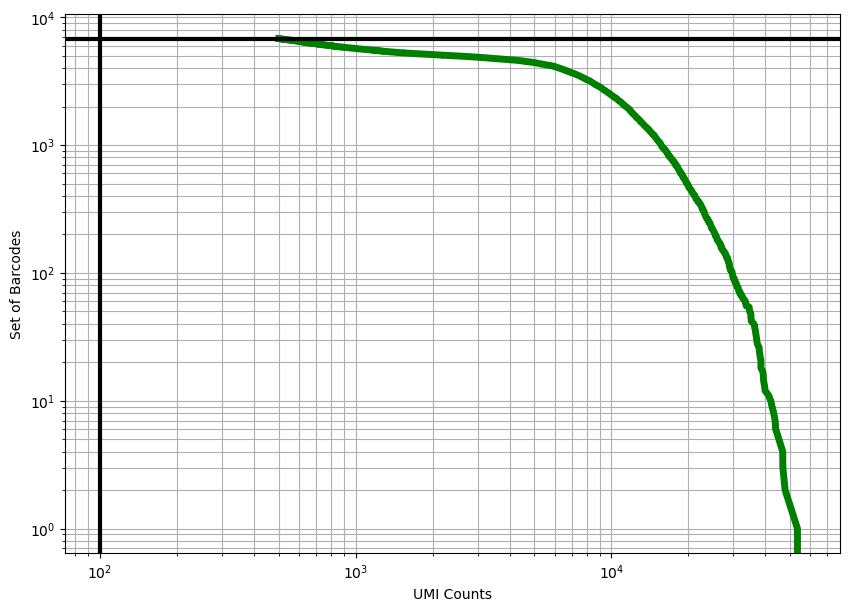

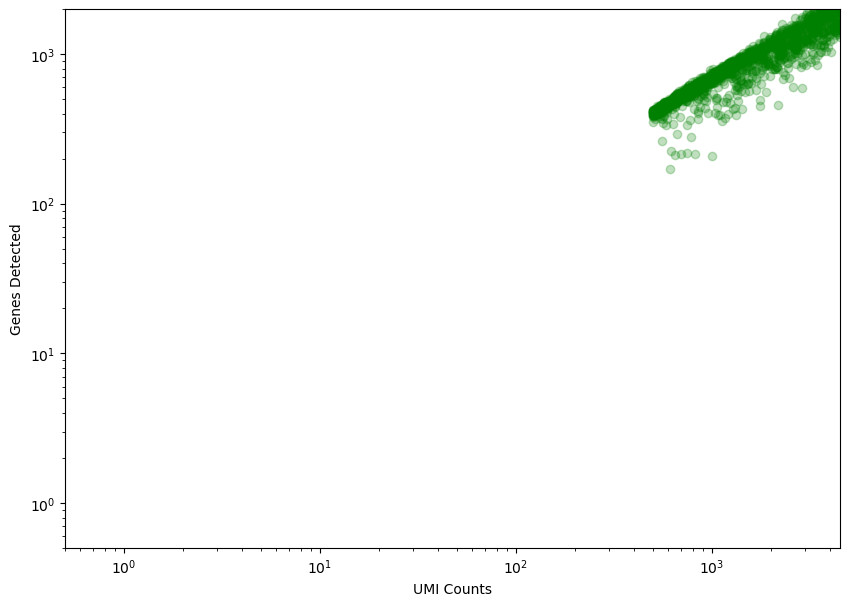

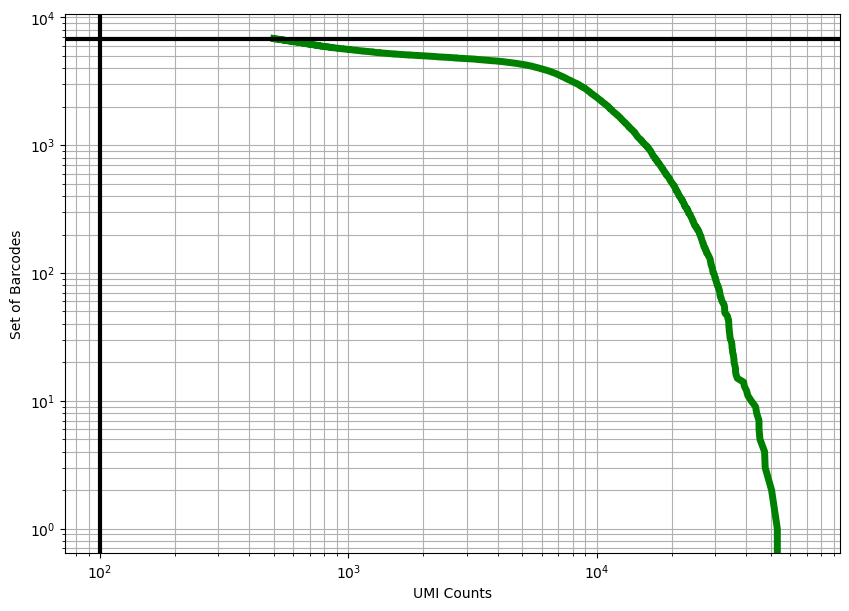

In [3]:
def saturation_plot(adata):
    # Create a plot showing genes detected as a function of UMI counts.
    fig, ax = plt.subplots(figsize=(10, 7))

    x = np.asarray(adata.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')

    ax.set_xlim((0.5, 4500))
    ax.set_ylim((0.5, 2000))

    plt.show()

def knee_plot(adata, umi_cutoff):
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > umi_cutoff][::-1][0]

    fig, ax = plt.subplots(figsize=(10, 7))

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=umi_cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")

    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Set of Barcodes")

    plt.grid(True, which="both")
    plt.show()

def quality_ctrl_plots(adata, umi_cutoff):
    saturation_plot(adata)
    knee_plot(adata, umi_cutoff)

umi_cutoffs = [100, 100, 100, 100]
for adata, umi_cutoff in zip(sample_adatas, umi_cutoffs):
    saturation_plot(adata)
    knee_plot(adata, umi_cutoff)